# Combined Processing Algorithm

Example simulating the ability of the array to both simultaneously locate and isolate sources

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pyroomacoustics as pra
from pyroomacoustics.directivities import (
    DirectivityPattern,
    DirectionVector,
    CardioidFamily,
)
from scipy.io import wavfile
from scipy.signal import resample
from playsound import playsound

### Room parameters

In [51]:
fs = 8000 # audio sampling frequency - global (set to freq of input file)

room_x = 10 # stage width
room_y = 20 # room length
order = 0 # reflection order
sigma2_n = 5e-7 # microphone noise variance estimate
v_sound = 343.0 # speed of sound in air

m = pra.make_materials(
    ceiling="hard_surface",
    floor="stage_floor",
    east="brickwork",
    west="brickwork",
    north="brickwork",
    south="brickwork",
) # materials of each surface of room, defines signal absorption

room = pra.ShoeBox([room_x, room_y], fs=fs, materials=m, max_order=order, air_absorption=True, ray_tracing=False)

### Place mics

In [52]:
# design parameters of array
array_loc = [5, 15] # x/y location of array center
n_mics = 8 # number of microphones
sep = 0.3 # microphone separation

N = 1024 # fft length - defines N/2 + 1 frequency bands

R = pra.linear_2D_array(center=array_loc, M=n_mics, phi=0, d=sep)
mic_array = pra.Beamformer(R, room.fs, N) # uses omnidirectional mics by default
room.add_microphone_array(mic_array)

### Place sources

In [53]:
source_locs = [[3, 19], [5, 19], [7, 19]] # locations of each source in 3D space (can modify)
source_inputs = ['input_samples/singing_8000.wav', 'input_samples/german_speech_8000.wav', 'input_samples/cmu_arctic_us_aew_a0001.wav'] # filepaths to wav files being played by the source
azimuths = []

for i in range(len(source_locs)):
    rate, audio = wavfile.read(source_inputs[i])

    # ensure sampling rates of all audio matches
    if rate != fs:
        num_samples = int(len(audio) * fs / rate)
        audio = resample(audio, num_samples)
    
    room.add_source(source_locs[i], signal=audio, delay=0)

    # ground truth azimuths (calculated relative to the x axis)
    azimuths.append(180/np.pi * math.atan2(source_locs[i][1] - array_loc[1], source_locs[i][0] - array_loc[0]))
    
azimuths.sort()
print('Source azimuths:', azimuths)

Source azimuths: [63.43494882292201, 90.0, 116.56505117707799]


### Locate sources with DOA

In [54]:
room.compute_rir()
room.simulate()

# short-time fourier transform of signal
X = np.array(
    [
        pra.transform.stft.analysis(signal, N, N // 2).T
        for signal in room.mic_array.signals
    ]
)

# NormMUSIC algorithm selected, recommended over MUSIC
n_source = 3
doa = pra.doa.normmusic.NormMUSIC(R, fs, N, c=v_sound, num_src=n_source, mode='far', azimuth=np.linspace(0, 180, 30)*np.pi/180)
doa.locate_sources(X, freq_bins=np.arange(1, N))
doa_azimuths = doa.azimuth_recon
doa_azimuths.sort()
azimuth_errors = [azimuths[i] - doa_azimuths[i] * 180.0/np.pi for i in range(len(azimuths))]

print("Recovered azimuths:", doa_azimuths * 180.0/np.pi, "degrees")
print("Angular Errors:", azimuth_errors, "degrees")

Recovered azimuths: [ 62.06896552  86.89655172 117.93103448] degrees
Angular Errors: [1.3659833056806292, 3.103448275862064, -1.3659833056806292] degrees


### Isolate sources with beamforming

In [55]:
# add guessed locations of sources to room
guess_dist = 5 # guessed distance away from array - choose far distance for precise beam
guess_source_locs = np.empty((2, n_source))

for i in range(n_source):
    guess_source_locs[0, i] = array_loc[0] + guess_dist*np.cos(doa_azimuths[i])
    guess_source_locs[1, i] = array_loc[1] + guess_dist*np.sin(doa_azimuths[i])

# Beamforming algorithm for each source
out_filepath = 'output_samples/DOA_Combined'
# guessed_sources = [room.sources[i][0:1] for i in range(n_source, 2*n_source)]

for i in range(guess_source_locs.shape[1]):
    current_interferers = guess_source_locs
    current_interferers = np.delete(current_interferers, i, 1)

    interf = pra.soundsource.SoundSource([0, 0])
    interf.images = current_interferers

    source = pra.soundsource.SoundSource([0, 0])
    source.images = np.array([[guess_source_locs[0, i]], [guess_source_locs[1, i]]])

    mic_array.rake_one_forcing_weights(
        source=source,
        interferer=interf,
        R_n=sigma2_n * np.eye(mic_array.M) # estimated noise covariance matrix
    )
    mic_array.filters_from_weights() # process with time domain filters for now, can also use FD directly

    # compute SIR, averaged across all frequency bands
    SIR_sum = 0
    for f in mic_array.frequencies:
        current_SIR = mic_array.snr(source, interf, f, dB=True)
        if math.isnan(current_SIR) == False:
            SIR_sum += current_SIR
            print(f'frequency band: {f:.2f}, SINR: {current_SIR:.2f}')
    SIR_avg = SIR_sum / len(mic_array.frequencies)
    print(f'average SINR: {SIR_avg:.2f}')

    # save processed sound as output
    output = mic_array.process()
    out_norm = pra.normalize(output)
    wavfile.write(out_filepath + '/isolated_src' + str(i+1) + '.wav', fs, out_norm)

# save sound from middle mic as an estimated raw input
raw_mic = pra.normalize(mic_array.signals[mic_array.M // 2])
wavfile.write(out_filepath + '/combined_8000_mic_' + str(mic_array.M // 2) + '.wav', fs, raw_mic)

frequency band: 0.00, SINR: 36.43
frequency band: 7.81, SINR: 40.06
frequency band: 15.62, SINR: 46.18
frequency band: 23.44, SINR: 51.49
frequency band: 31.25, SINR: 55.78
frequency band: 39.06, SINR: 59.31
frequency band: 46.88, SINR: 62.28
frequency band: 54.69, SINR: 64.84
frequency band: 62.50, SINR: 67.08
frequency band: 70.31, SINR: 69.08
frequency band: 78.12, SINR: 70.88
frequency band: 85.94, SINR: 72.52
frequency band: 93.75, SINR: 74.03
frequency band: 101.56, SINR: 75.44
frequency band: 109.38, SINR: 76.77
frequency band: 117.19, SINR: 78.02
frequency band: 125.00, SINR: 79.22
frequency band: 132.81, SINR: 80.37
frequency band: 140.62, SINR: 81.49
frequency band: 148.44, SINR: 82.58
frequency band: 156.25, SINR: 83.66
frequency band: 164.06, SINR: 84.73
frequency band: 171.88, SINR: 85.79
frequency band: 179.69, SINR: 86.85
frequency band: 187.50, SINR: 87.91
frequency band: 195.31, SINR: 88.97
frequency band: 203.12, SINR: 90.02
frequency band: 210.94, SINR: 91.04
frequen

### Evaluate performance

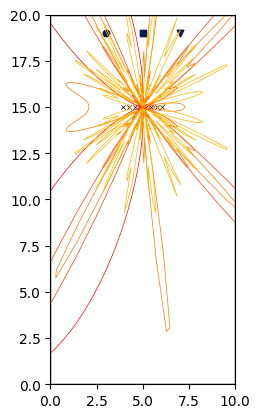

In [56]:
# plot peam pattern
fig, ax = room.plot(freq=[250, 1000, 2000, 4000], img_order=0)

In [57]:
playsound(out_filepath + '/combined_8000_mic_8.wav')

In [62]:
playsound(out_filepath + '/isolated_src1.wav')

In [61]:
playsound(out_filepath + '/isolated_src2.wav')

In [63]:
playsound(out_filepath + '/isolated_src3.wav')